In [1]:
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import numpy as np

In [8]:
match_ids = ['30c3a961-eae1-4031-8b85-5d4d04ac9a5d', '516d161f-fa9e-4047-b228-12e5941ae560', '6d2fedaf-10f8-4b53-8abb-92e03bfd461e', '8e25dd45-7b49-42b0-9124-6ec213396603', '23a1c888-5b02-4cdd-a436-d48aa65964fe']

In [9]:
random_ids = ['32763946-5ca3-4ea6-ad39-de91eb9e8908', '03f6f506-adb7-4037-a58f-ea782c4a206e', 'cd463148-6422-4a05-80b8-569ab2e7489e', 'afd0f268-4c02-4dce-b439-3582b0367307', '47abdf9c-1df1-40e5-b785-f5684891e705']

In [10]:
static_ids = ['6c45ea6f-e0ea-4996-a6f5-b67ae3c11029', '95e35daa-1047-4413-ae61-1b2fc24cff55', '6a950ed7-f870-42c7-aee6-ed4527870591', '3eb9386c-2059-4d67-837d-27e7cf452e1b', '20234862-4683-4cf5-af78-8b9afb20713b']

In [11]:
run_dir = "../experiments/runs"

In [12]:
def get_trajectories(sim_ids):
    trajectories = []
    for sim_id in sim_ids:
        df = pd.read_csv(os.path.join(run_dir, sim_id, "output.csv"))
        df['sim-id'] = sim_id
        trajectories.append(df)
    trajectories = pd.concat(trajectories, axis=0)
    trajectories['datetime'] = pd.to_datetime(trajectories['datetime'])
    trajectories['date'] = trajectories['datetime'].dt.date
    
    total_reward = trajectories[['date', 'display', 'revenue', 'sim-id']].groupby(["sim-id","display", "date"]).agg(
    {"revenue": sum}
    )
    total_reward = total_reward.reset_index().sort_values(by=['sim-id', 'display','date'])
    mu = total_reward.groupby(['display', 'date']).agg({'revenue': np.mean}).reset_index()
    #sig = total_reward.groupby(['display', 'date']).agg({'revenue': np.std}).reset_index()
    
    #mu['upper'] = mu['revenue'] + sig['revenue']*1.96
    #mu['lower'] = mu['revenue'] - sig['revenue']*1.96
    mu['cumulative'] = mu.groupby(["display"]).cumsum()
    return mu


In [13]:
random_policy = get_trajectories(random_ids)
match_policy = get_trajectories(match_ids)

In [14]:
static_policy = get_trajectories(static_ids)

In [15]:
display_list = list(random_policy['display'].unique())

/opt/anaconda3/envs/allocation-rl/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


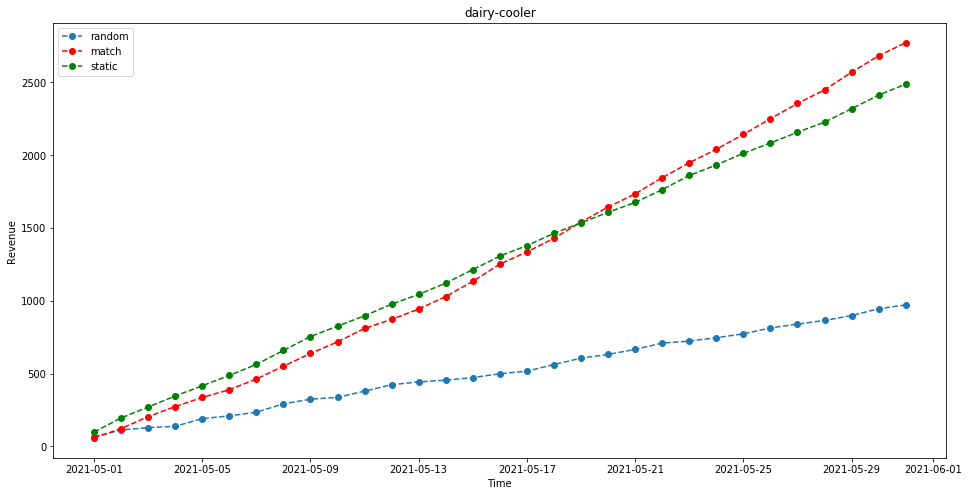

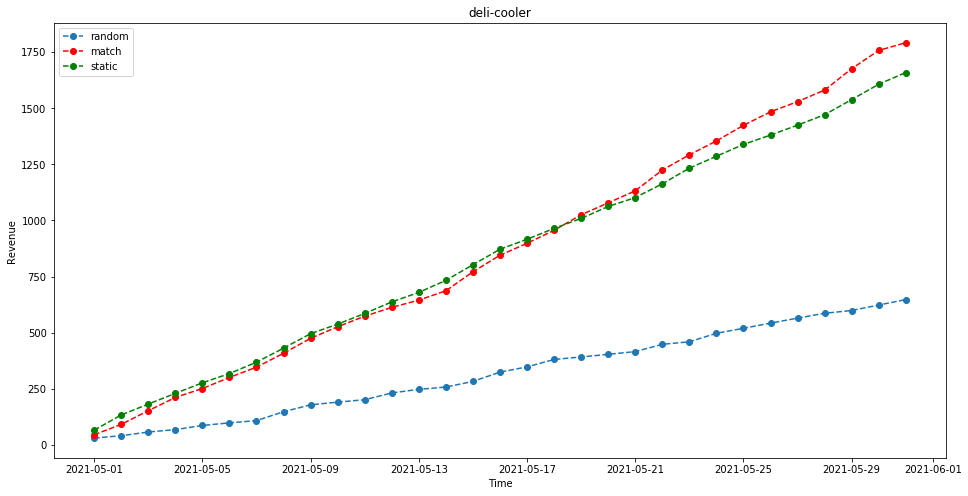

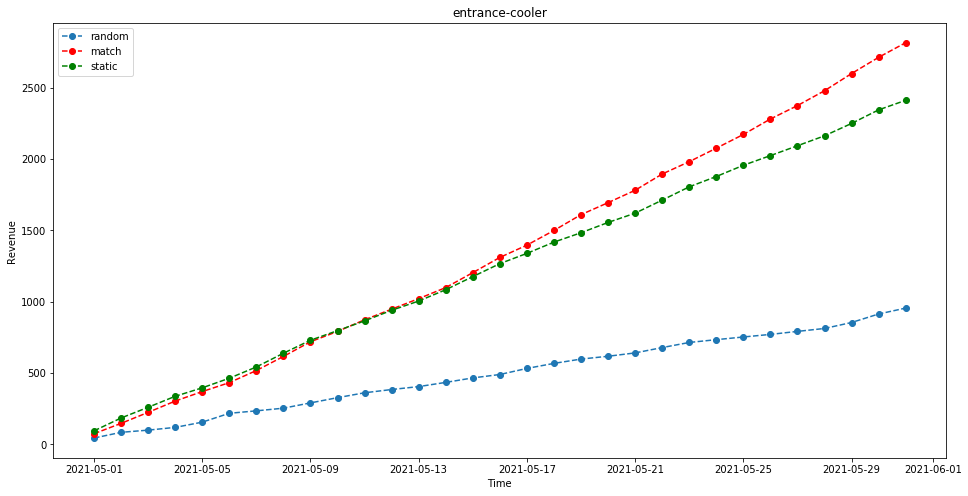

In [16]:
for d in display_list:
    
    rand_disp = random_policy[random_policy['display'] == d]
    match_disp = match_policy[match_policy['display'] == d]
    static_disp = static_policy[static_policy['display'] ==d]
    
    fig = plt.figure(figsize=(16, 8))
    
    # random
    plt.plot(rand_disp["date"], rand_disp["cumulative"], "--", marker='o',  label='random')
    #plt.fill_between(rand_disp["date"],rand_disp["lower"], rand_disp["upper"], alpha=.1)
    # match
    plt.plot(match_disp["date"], match_disp["cumulative"], "--", marker='o', color='red',  label='match')
    #plt.fill_between(match_disp["date"],match_disp["lower"], match_disp["upper"], alpha=.1, color='red')
    # static
    plt.plot(static_disp["date"], static_disp["cumulative"], "--", marker='o', color='green',  label='static')
    #plt.fill_between(static_disp["date"],static_disp["lower"], static_disp["upper"], alpha=.1, color='green')
    
    
    
    plt.title(d)
    plt.xlabel("Time")
    plt.ylabel("Revenue")
    plt.legend(loc='best')

In [17]:
rand_output = random_policy[['display', 'cumulative']].groupby('display').max()
static_output = static_policy[['display', 'cumulative']].groupby('display').max()
match_output = match_policy[['display', 'cumulative']].groupby('display').max()

In [18]:
match_output['pct_gain_rand'] = 100*(match_output['cumulative'] - rand_output['cumulative'])/ rand_output['cumulative']

In [19]:
match_output['pct_gain_static'] = 100*(match_output['cumulative'] - static_output['cumulative'])/ static_output['cumulative']

In [20]:
match_output

,cumulative,pct_gain_rand,pct_gain_static
display,,,
dairy-cooler,2773.278,185.261493,11.437402
deli-cooler,1792.220,176.842895,8.013211
entrance-cooler,2815.326,194.802856,16.752718
